# 1 引言
<b>研究目的：</b>    
本文参考广发证券《基于日内高频数据的短周期选股因子研究-高频数据因子研究系列一》，对研报构造的因子做了实现，并复现了里面的结果，做出了分析。其中用个股日内高频数据构造选股因子，低频调仓的思路是一个很好的方向。

<b>研究内容：</b>    
基于个股日内高频数据，构建了已实现波动(Realized Volatility) 𝑅𝑉𝑜𝑙，已实现偏度(Realized Skewness)𝑅𝑆𝑘𝑒𝑤、已实现峰度(Realized Kurtosis)𝑅𝐾𝑢𝑟𝑡因子指标，考察这三个因子在回测区间内对个股收益率 的区别度。

<b>研究结论：</b>   
在三个因子中偏度$RSkew$因子最有效，分组区分度高，比较稳定，收益最高。

# 2 因子构建
因子构建过程摘自研报，具体因子指标构建如下:

1. 对于每个个股在交易日t，首先计算个股在特定分钟频率下第i个的收益率 $r_{t,i}$， <b>$r_{t,i}$ = $p_{t,i}$ − $p_{t,i-1}$</b>，其中$p_{t,i}$表示在交易日t，个股在第i个特定分钟频率下的对数价格，$p_{t,i-1}$表示在交易日t，个股在第i−1个特定分钟频率下的对数价格。

2. 对于每个个股，根据𝑟𝑡,𝑖分别计算个股在交易日t下的已实现方差(Realized Variance) $RDVar_t$、已实现偏度(Realized Skewness) $RDSkew_t$，已实现峰度(Realized kurtosis) $RDKurt_t$。其中:  

<font face="黑体" size=5>
$$RDVar_t = \sum\limits_{ i=1}^{n}r_{t,i}^2$$  
</font>

<font face="黑体" size=5>
$$RDSkew_t =  \frac {\sqrt N\sum\limits_{ i=1}^{n}r_{t,i}^3}{RDVar_t^{3/2}}$$  
</font>  
     
<font face="黑体" size=5>
$$RDKurt_t =  \frac {N \sum\limits_{ i=1}^{n}r_{t,i}^4}{RDVar_t^2}$$  
</font>

其中N表示个股在交易日t中特定频率的分钟级别数据个数，如在1分钟行情级别下，数据个数N为60*4=240；在5分钟行情级别下，数据个数N为240/5=48。




3. 对于每个个股在交易日t计算累计已实现波动(Realized Volatility)$RVol_t$， 已实现偏度(Realized Skewness)$RSkew_t$、已实现峰度(Realized Kurtosis) $RKurt_t$ ，其中:
<font face="黑体" size=5>
$$RVol_t = \left(\frac{242}{n} {\sum\limits_{ i=0}^{n}}RDVar_{t-i}\right)^{1/2}$$   
</font>

<font face="黑体" size=5>
$$RSkew_t =  \frac{1}{n}{\sum\limits_{ i=0}^{n}}RDSkew_{t-i}$$  
</font>  
     
<font face="黑体" size=5>
$$RKurt_t =  \frac{1}{n}{\sum\limits_{ i=0}^{n}}RDKurt_{t-i}$$ 
</font>

4. 在每期调仓日截面上，按照上述公式计算每个个股的已实现波动(Realized Volatility)$RVol_t$，已实现偏度(Realized Skewness)$RSkew_t$、已实现峰度(Realized Kurtosis)$RKurt_t$指标，针对每个由高频数据计算得到的因子指标在历史上的分档组合表现，试图寻找出相对有效的因子指标。

# 3 构造因子数据

计算因子值的过程比较慢，大概耗时1小时左右。如果直接下载我构造好的数据文件（factor_dict.pkl）上传到研究里可以跳过这一步，直接到因子特征展示开始执行。

以下开始计算因子值：

In [9]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/20900
# 标题：精英任务获奖作品——作者：一梦春秋

import pandas as pd
import numpy as np
from jqdata import *
import math
from pandas import *
from datetime import date, timedelta

N = 48
n = 5

In [2]:
# 获取某个交易日的因子值
def get_one_trade_day_data(cache = {}, stocks = None, trade_date = None):
#     print(trade_date)

    # 后面需要在交易日t计算累计已实现波动等数据，需要获取交易日t到交易日t-n之间的交易日
    trade_days = get_trade_days(start_date=None, end_date=trade_date, count=n)

    # dataframe的index，为股票code
    factor_df_index = []

    # 计算得到的因子数值
    factor_df_data = []
    for security in stocks:
#         print(security)

        # 获取收盘价、是否停牌。
        price_info = get_price(security, start_date=None, end_date=trade_date, frequency='daily',
                               fields=['paused', 'close'], skip_paused=False, fq='pre',
                               count=n)

        # 交易日t 当日的收盘价
        t_close = price_info.iloc[-1]['close']

        # 过滤停牌数据(如果过去n日某天有停牌，后面计算偏度时的分母是0会报除0异常)
        # 如果有paused为1的数据，会被drop掉 则长度是0
        if len(price_info.T.replace(1.0, np.nan).dropna().index.values.tolist()) == 0:
#             print("含有停牌数据,continue")
            continue

        # 前n个交易日已实现方差之和
        sum_rd_var = 0.0

        # 前n个交易日已实现偏度之和
        sum_rd_skew = 0.0

        # 前n个交易日已实现峰度之和
        sum_rd_kurt = 0.0

        # 遍历t-n交易日 到 t交易日
        for trade_day in trade_days:
            # 如果重复调用get_bars实在是太慢了，这里缓存一下数据
            if trade_day in cache.keys() and security in cache[trade_day].keys():
                bars = cache[trade_day][security]
            else:
                # 这里要获取交易日当天的数据 所以end_dt要+1
                # 研报中N为48，对应的频率为5分钟(一个交易日有60*4=240分钟，240/48 = 5)
                bars = get_bars(security, N, unit='5m',
                                fields=['date', 'open', 'high', 'low', 'close'],
                                include_now=False, end_dt=trade_day + timedelta(days=1), fq_ref_date=None)
                if trade_day not in cache.keys():
                    cache[trade_day] = {}
                cache[trade_day][security] = bars

            # 个股收益率平方、立方、4次方之和
            sum_rt2 = 0.0
            sum_rt3 = 0.0
            sum_rt4 = 0.0

            for i in range(1, N):
                # 个股在第i个特定分钟频率 下的对数价格
                pi = math.log(bars[i]['close'])

                # 个股在第i-1个特定分钟频率 下的对数价格
                pi_1 = math.log(bars[i - 1]['close'])

                # 个股在特定分钟频率下第i个的收益率
                rt = pi - pi_1

                sum_rt2 += math.pow(rt, 2)
                sum_rt3 += math.pow(rt, 3)
                sum_rt4 += math.pow(rt, 4)

            # 交易日t下的已实现方差
            rd_var = sum_rt2

            # 交易日t下的已实现偏度
            if sum_rt3 == 0:
                rd_skew = 0
            else:
                rd_skew = math.sqrt(N) * sum_rt3 / (math.pow(rd_var, 3 / 2))

            # 交易日t下的已实现峰度
            if sum_rt4 == 0:
                rd_kurt = 0
            else:
                rd_kurt = N * sum_rt4 / (math.pow(rd_var, 2))

            sum_rd_var += rd_var
            sum_rd_skew += rd_skew
            sum_rd_kurt += rd_kurt

        # 累计已实现波动
        r_vol = math.sqrt((242.0 / n) * sum_rd_var)

        # 已实现偏度
        r_skew = (1.0 / n) * sum_rd_skew

        # 已实现峰度
        r_kurt = (1.0 / n) * sum_rd_kurt

        # 数据填充
        factor_df_index.append(security)
        factor_df_data.append([t_close, r_vol, r_skew, r_kurt])
#         print(security, [t_close, r_vol, r_skew, r_kurt])

    # 生成dataframe，行索引为股票code，列名为'close', 'r_vol', 'r_skew', 'r_kurt'
    factor_df = pd.DataFrame(data=factor_df_data, index=factor_df_index, columns=['close', 'r_vol', 'r_skew', 'r_kurt'])
    return factor_df

In [7]:
# 按照研报要求，去除上市不满一年的股票，剔除ST股
def filter_stock(stocks, date):
    # 去除上市距beginDate不足6个月的股票
    stock_list = []
    for stock in stocks:
        start_date = get_security_info(stock).start_date
        if start_date < (date - timedelta(days=365)):
            stock_list.append(stock)
    # 剔除ST股
    st_data = get_extras('is_st', stock_list, count=1, end_date=date)
    stock_list = [stock for stock in stock_list if not st_data[stock][0]]
    return stock_list

In [8]:
# 获取样本区间内的因子数据

# 研报中样本区间:2007年1月1日至2019年3月27日
# 2007-2019数据实在太多了，这里减一半，使用2013-2019，也一样涵盖牛市和熊市
start_date = date(2013, 1, 1)
end_date = date(2019, 3, 27)
trade_days = get_trade_days(start_date=start_date, end_date=end_date, count=None)

cache = {}
# key为日期，value为dataframe,dataframe的行是股票code，列是收盘价和因子值
factor_dict = {}
for i in range(0, len(trade_days)):
    '''
    最开始我还按天计算的因子值 想着调仓日可以设置灵活一点，也可以计算1日IC
    后来数据实在是多，还是每5天计算一次吧
    '''
    if i % n != 0:
        continue
        
    trade_day = trade_days[i]
    print(trade_day)
    
    # 全市场
    # stocks = list(get_all_securities(['stock']).index)
    
    # 中证500成分股
    stocks = get_index_stocks('000905.XSHG', trade_day)
    
    '''
    全市场、2007-2019数据实在太多了，留言询问了一下，使用中证500 三年以上的数据就可以了
    这里我使用中证500, 2013-2019的数据
    '''
    
    # 按照研报要求过滤次新、ST
    stocks = filter_stock(stocks, trade_day)

    factor_df = get_one_trade_day_data(cache = cache, stocks=stocks, trade_date=trade_day)
    factor_dict[trade_day] = factor_df
    
    # 研究的内存不够 只缓存最近5天的数据; 不过如果5天计算一次因子值，这个缓存也没什么用了
    if len(cache) > 5:
        to_del_key_list = []
        for key in cache.keys():
            if key not in trade_days[i - 5: i]:
                to_del_key_list.append(key)
        for key in to_del_key_list:
            del cache[key]

print(factor_dict)

2013-01-04
2013-01-11
2013-01-18
2013-01-25
2013-02-01
2013-02-08
2013-02-22
2013-03-01
2013-03-08
2013-03-15
2013-03-22
2013-03-29
2013-04-09
2013-04-16
2013-04-23
2013-05-03
2013-05-10
2013-05-17
2013-05-24
2013-05-31
2013-06-07
2013-06-19
2013-06-26
2013-07-03
2013-07-10
2013-07-17
2013-07-24
2013-07-31
2013-08-07
2013-08-14
2013-08-21
2013-08-28
2013-09-04
2013-09-11
2013-09-18
2013-09-27
2013-10-11
2013-10-18
2013-10-25
2013-11-01
2013-11-08
2013-11-15
2013-11-22
2013-11-29
2013-12-06
2013-12-13
2013-12-20
2013-12-27
2014-01-06
2014-01-13
2014-01-20
2014-01-27
2014-02-10
2014-02-17
2014-02-24
2014-03-03
2014-03-10
2014-03-17
2014-03-24
2014-03-31
2014-04-08
2014-04-15
2014-04-22
2014-04-29
2014-05-08
2014-05-15
2014-05-22
2014-05-29
2014-06-06
2014-06-13
2014-06-20
2014-06-27
2014-07-04
2014-07-11
2014-07-18
2014-07-25
2014-08-01
2014-08-08
2014-08-15
2014-08-22
2014-08-29
2014-09-05
2014-09-15
2014-09-22
2014-09-29
2014-10-13
2014-10-20
2014-10-27
2014-11-03
2014-11-10
2014-11-17

In [9]:
# 把计算出的因子数据写入文件 方便后续调用
import pickle

pkl_file = open('factor_dict.pkl', 'wb')
pickle.dump(factor_dict, pkl_file, 0)
pkl_file.close()

# 4 因子特征展示

通过上文中的代码，已经获取到了中证500成分股2013-2019的因子数据。

以下分别从因子频率分布、因子百分位走势2个维度展示因子特征。
## 1 频率分布

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

# 读取因子数据文件
pkl_file = open('factor_dict.pkl', 'rb')
factor_dict = pickle.load(pkl_file)
pkl_file.close()

# print(factor_dict)

import matplotlib.dates as mdate
# 设置字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

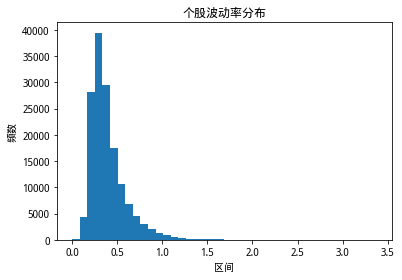

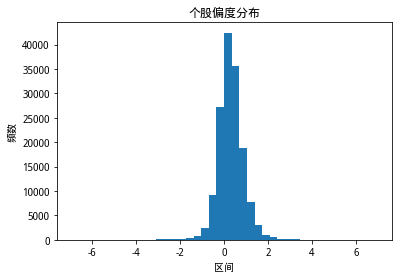

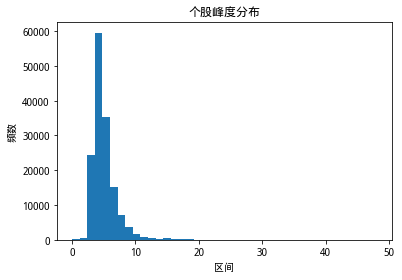

In [2]:
market_vol = []
market_skew = []
market_kurt = []

for date in factor_dict:
    factor_df = factor_dict[date]
    for i in range(0, len(factor_df)):
        factor = factor_df.iloc[i]
        market_vol.append(factor['r_vol'])
        market_skew.append(factor['r_skew'])
        market_kurt.append(factor['r_kurt'])

"""
绘制直方图
data:必选参数，绘图数据
bins:直方图的长条形数目，可选项，默认为10
density:是否将得到的直方图向量归一化，可选项，默认为0，代表不归一化，显示频数。normed=1，表示归一化，显示频率。
facecolor:长条形的颜色
edgecolor:长条形边框的颜色
alpha:透明度
"""
# 这个颜色是我把研报的图截图用取色器取出来的，为什么画出来还是有色差？
color = "#1F77B4"
plt.hist(market_vol, bins=40, density=0, facecolor=color, edgecolor=None, alpha=1)
# 显示横轴标签
plt.xlabel("区间")
# 显示纵轴标签
plt.ylabel("频数")
# 显示图标题
plt.title("个股波动率分布")
plt.show()

plt.hist(market_skew, bins=40, density=0, facecolor=color, edgecolor=None, alpha=1)
# 显示横轴标签
plt.xlabel("区间")
# 显示纵轴标签
plt.ylabel("频数")
# 显示图标题
plt.title("个股偏度分布")
plt.show()

plt.hist(market_kurt, bins=40, density=0, facecolor=color, edgecolor=None, alpha=1)
# 显示横轴标签
plt.xlabel("区间")
# 显示纵轴标签
plt.ylabel("频数")
# 显示图标题
plt.title("个股峰度分布")
plt.show()

从以上因子分布三图看出，整个A股市场个股的波动率分布整体上呈现右偏分布；个股的偏度分布，整体偏度水平保持在零附近，呈现较为明显厚尾状态；个股的峰度分布与个股波动率水平类似，分布整体上右偏，且样本内个股的峰度水平大部分大于3，呈现厚尾的现象。

和研报中的三个因子分布图情况和结论相同。



## 2 百分位走势

In [3]:
# 显示因子百分位走势
def show_percent_factor_value(factor_dict, factor_name, legend_loc):
    # 百分位走势5档颜色 蓝 橙 绿 红 紫
    color_list = ['#5698c6', '#ff9e4a', '#60b760', '#e05c5d', '#ae8ccd']

    label_list = ['10', '25', 'median', '75', '90']

    # 这里需要用每天的因子数据分档，计算出5个折线
    y_list = [[], [], [], [], []]

    for date in factor_dict:
        factor_df = factor_dict[date]
        day_factor_values = []
        for i in range(0, len(factor_df)):
            factor = factor_df.iloc[i]
            # 'r_vol', 'r_skew', 'r_kurt'
            day_factor_values.append(factor[factor_name])

        # 把day_factor_values分为5档
        day_factor_values = np.array(day_factor_values)
        day_factor_values.sort()

        # 研报的5个分位数分别是10 25 50 75 90
        q_list = [0.10, 0.25, 0.50, 0.75, 0.90]
        for i in range(0, len(q_list)):
            # 对应分位数位置
            q_index = int(q_list[i] * len(day_factor_values))

            # 对应分位数位置的因子值
            factor_value = day_factor_values[q_index]
            y_list[i].append(factor_value)

    # 可以设置生成图片的大小
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))  # 设置时间标签显示格式
    ax.xaxis.set_major_locator(mdate.DayLocator())
    ax.set_title(factor_name + '百分位走势')

    for i in range(0, len(y_list)):
        yi = y_list[i]
        ax.plot(yi, color_list[i], label=label_list[i])

    
    x = np.arange(0, len(factor_dict),50)
    x_label = []
    for i in range(0,len(factor_dict)):
        if i in x:
            date = list(factor_dict.keys())[i]
            x_label.append(date)
        
    plt.xticks(x, x_label, rotation='vertical')

    # 显示具体数值的标注
    # for i in range(0, len(y_list)):
    #     yi = y_list[i]
    #
    #     for a, y in zip(x, yi):
    #         # print(a,y,y)
    #         plt.text(a, y, y, ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=360)
    # 显示横轴标签
    plt.xlabel("TRADE_DT")
    # 显示纵轴标签
    plt.ylabel("因子值")
    # 图例的位置
    legend = ax.legend(loc=legend_loc, shadow=False)

    plt.show()

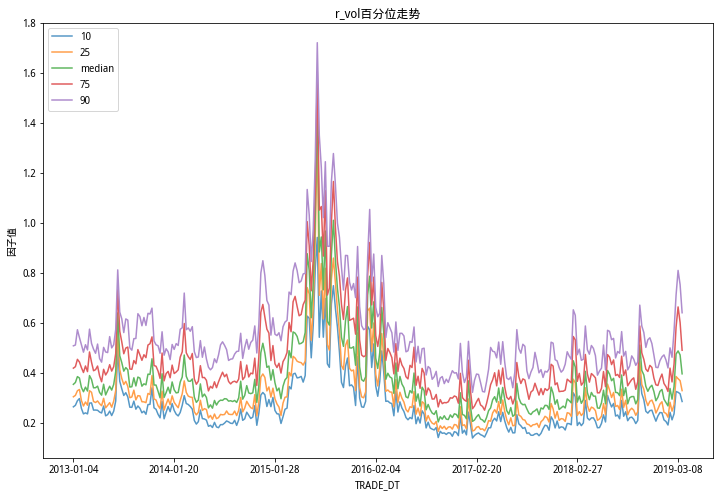

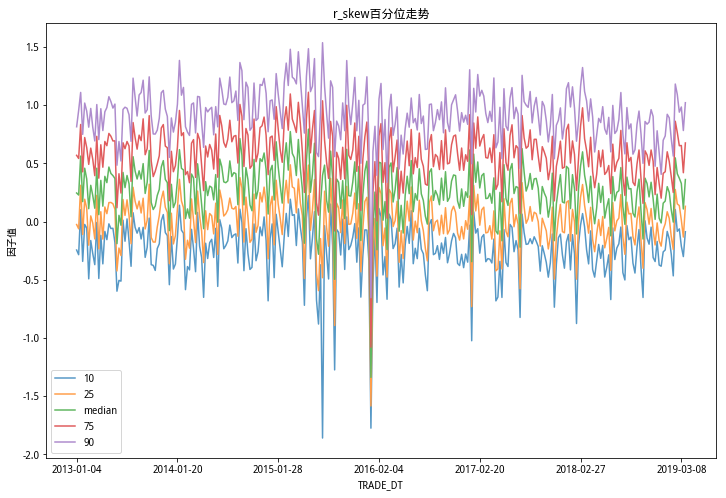

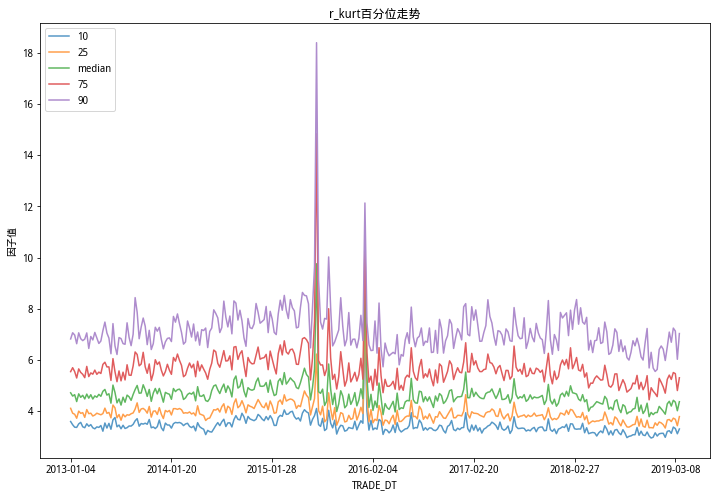

In [4]:
# 'r_vol', 'r_skew', 'r_kurt'
show_percent_factor_value(factor_dict, 'r_vol', 'upper left')
show_percent_factor_value(factor_dict, 'r_skew', 'lower left')
show_percent_factor_value(factor_dict, 'r_kurt', 'upper left')

从以上三图看出，个股的波动率在不同的时间维度上变化较大，当市场趋势行情较明显时候，个股波动率水平整体上呈现上升的趋势；个股偏度水平整体较为稳定；个股峰度水平在极端行情下峰度更高，且不同分位数差异更加明显。

和研报中的三个因子百分位走势图情况和结论相同。

# 5 实证分析

## 1 因子选股分档表现

In [5]:
def group_df(df, count):
    length = int(len(df) / count)

    groups = []
    for i in range(0, count - 1):
        groups.append(df[length * i:length * (i + 1)])
    groups.append(df[length * (count - 1):])
    return groups


# 展示某因子的分档收益率
def show_factor_level_return_rate(ret_df, factor_dict, factor_name):
    # 5档颜色 蓝 橙 绿 红 紫
    color_list = ['#5698c6', '#ff9e4a', '#60b760', '#e05c5d', '#ae8ccd']

    label_list = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

    # 这里需要用每天的因子数据分档，计算出5个折线
    y_list = [[], [], [], [], []]

    # 收益率折线图从0开始
    for i in range(0, 5):
        yi = y_list[i]
        yi.append(0)

    pre_date = None
    for date in factor_dict:
        if type(pre_date) == type(None):
            pre_date = date
            continue

        # pre_date为date的上一个调仓日，这里获取上一个调仓日的因子值
        factor_df = factor_dict[pre_date].dropna()
        factor_df = factor_df.sort_values(by=factor_name)

        # 获取上一个调仓日到本调仓日的收益率
        ret = ret_df.loc[pre_date]
        factor_df['ret'] = ret

        # 把上一个调仓日的因子值分为5档
        groups = group_df(factor_df, 5)
        for i in range(0, len(groups)):
            yi = y_list[i]
            # 这里为了简便采用等权重持仓，直接求平均就可以了
            current_ret = groups[i]['ret'].mean()

            # 累计收益率
            sum_ret = yi[len(yi) - 1] + current_ret

            yi.append(sum_ret)

        pre_date = date
#     print(y_list)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    # ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))  # 设置时间标签显示格式
    # ax.xaxis.set_major_locator(mdate.DayLocator())
    ax.set_title(factor_name + '累计收益率')

    for i in range(0, len(y_list)):
        yi = y_list[i]
        ax.plot(yi, color_list[i], label=label_list[i])

    x = np.arange(0, len(factor_dict),50)
    x_label = []
    for i in range(0,len(factor_dict)):
        if i in x:
            date = list(factor_dict.keys())[i]
            x_label.append(date)
        
    plt.xticks(x, x_label, rotation='vertical')
    
    # 显示横轴标签
    plt.xlabel("TRADE_DT")
    # 显示纵轴标签
    plt.ylabel("收益率")

    # 在图上展示具体的值
    # for i in range(0, len(y_list)):
    #     yi = y_list[i]
    #
    #     for a, y in zip(x, yi):
    #         plt.text(a, y, y, ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=360)  # 旋转45度显示
    legend = ax.legend(loc='upper left', shadow=False)

    plt.show()

In [7]:
# 求每天的收益率
import pandas as pd

ret_df_index = []
ret_df_data = []
for date in factor_dict:
    ret_df_index.append(date)
    factor_df = factor_dict[date]
    close_df = factor_df.T
    close_series = close_df.loc['close']
    ret_df_data.append(close_series)
ret_df = pd.DataFrame(data=ret_df_data, index=ret_df_index)
# 收盘价的变化率为收益率
ret_df = ret_df.pct_change()

# 上移，转为当期收益率
ret_df = ret_df.shift(-1)
ret_df = ret_df.fillna(0)

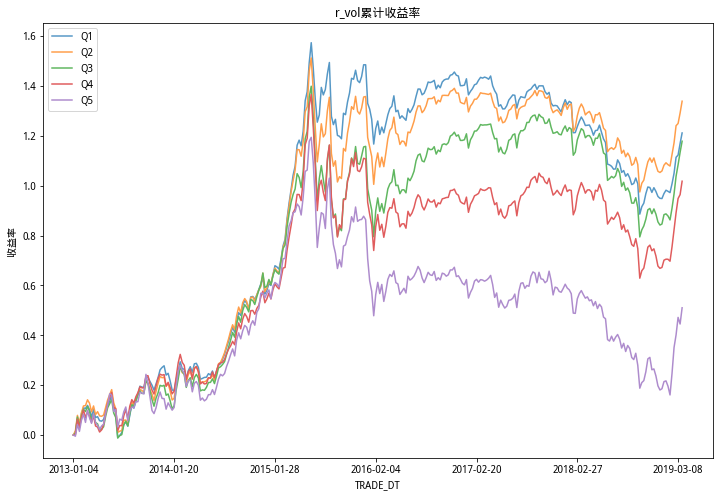

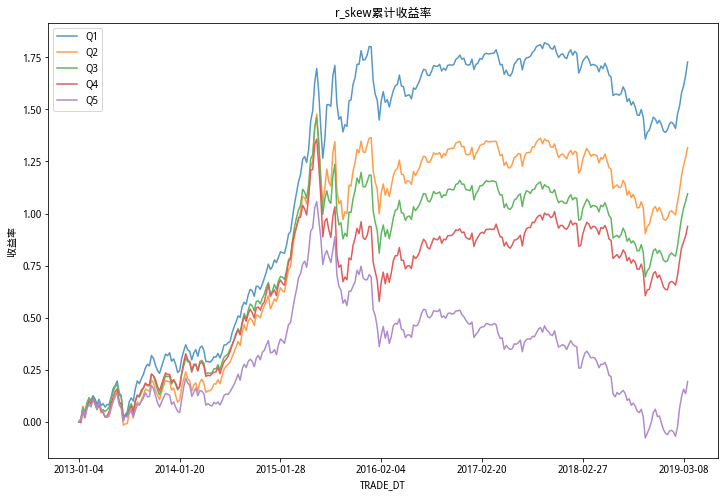

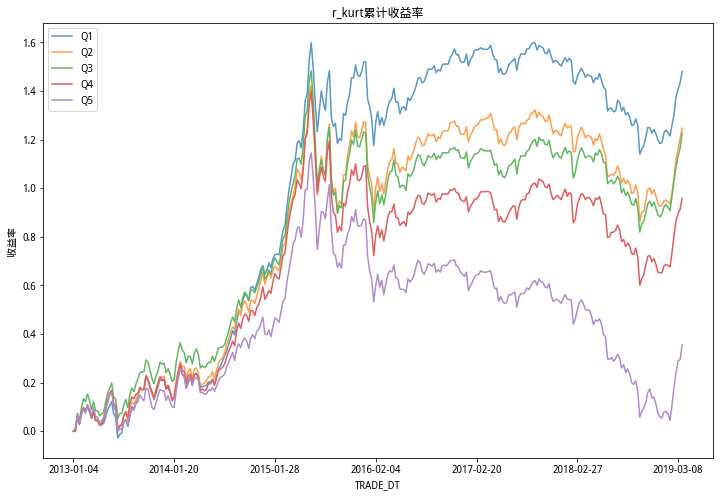

In [8]:
# 'r_vol', 'r_skew', 'r_kurt'
show_factor_level_return_rate(ret_df, factor_dict, 'r_vol')
show_factor_level_return_rate(ret_df, factor_dict, 'r_skew')
show_factor_level_return_rate(ret_df, factor_dict, 'r_kurt')

由以上累计收益率5档图看出，偏度$RSkew$因子分档很明显，单调性显著；$RVol$因子分档不明显，峰度$RKurt$因子的区分度比偏度$RSkew$略微弱一些，但好于$RVol$因子。

和研报结论相同。

## 2 因子多空收益

In [9]:
# 展示某因子的多空收益率（Bull and Bear）
def show_factor_bb_return_rate(ret_df, factor_dict, factor_name):
    color = 'red'
    label = '多空累计收益'

    # 多空收益率
    y_list = []

    # 收益率折线图从0开始
    y_list.append(0)

    pre_date = None
    for date in factor_dict:
        if type(pre_date) == type(None):
            pre_date = date
            continue

        # pre_date为date的上一个调仓日，这里获取上一个调仓日的因子值
        factor_df = factor_dict[pre_date].dropna()
        factor_df = factor_df.sort_values(by=factor_name)

        # 获取上一个调仓日到本调仓日的收益率
        ret = ret_df.loc[pre_date]
        factor_df['ret'] = ret

        
        # 把上一个调仓日的因子值分为5档
        groups = group_df(factor_df, 5)
        # Q1组 - Q5组
        current_bb_ret = groups[0]['ret'].mean() - groups[4]['ret'].mean()
        sum_bb_ret = y_list[len(y_list) - 1] + current_bb_ret
        y_list.append(sum_bb_ret)

        pre_date = date
#     print(y_list)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    # ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))  # 设置时间标签显示格式
    # ax.xaxis.set_major_locator(mdate.DayLocator())
    ax.set_title(factor_name + '多空累计收益率')

    ax.plot(y_list, color, label=label)
    
    

    x = np.arange(0, len(factor_dict),50)
    x_label = []
    for i in range(0,len(factor_dict)):
        if i in x:
            date = list(factor_dict.keys())[i]
            x_label.append(date)
        
    plt.xticks(x, x_label, rotation='vertical')
#     for label in ax.get_xticklabels():
#         label.set_visible(False)
#     for label in ax.get_xticklabels()[::50]:
#         label.set_visible(True)

    plt.xticks(rotation=360)  # 旋转45度显示
    legend = ax.legend(loc='upper left', shadow=False)

    plt.show()

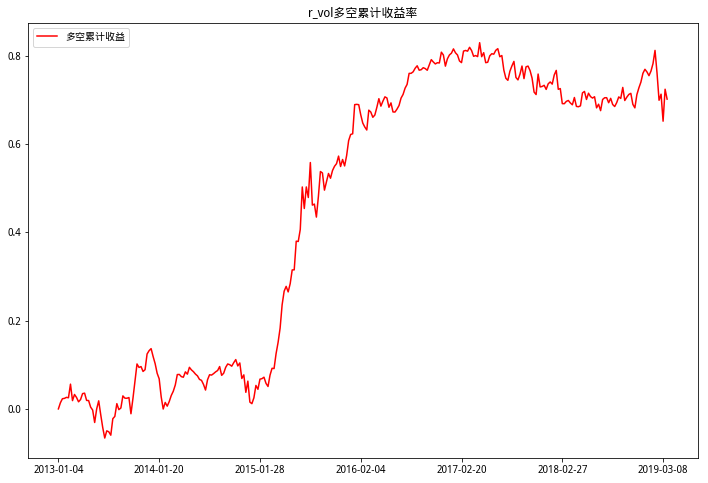

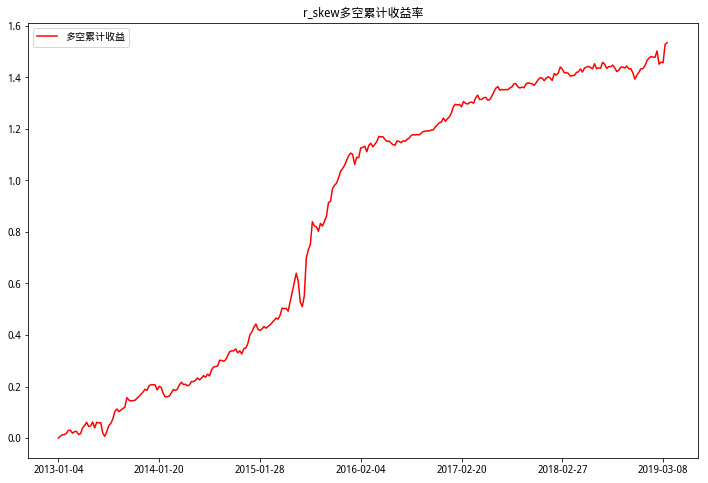

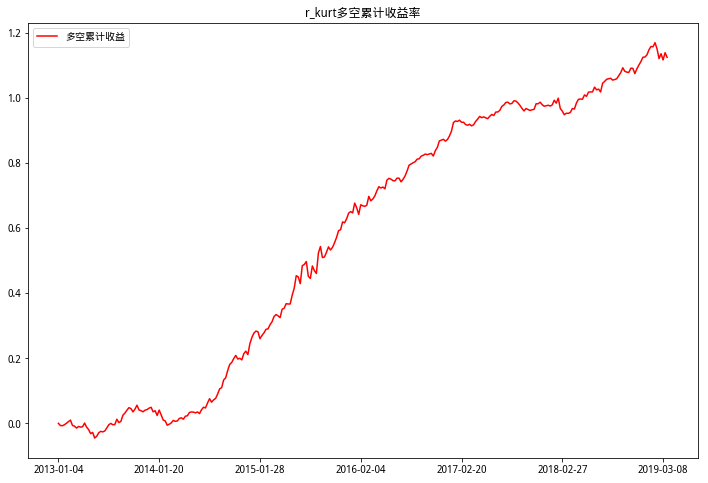

In [10]:
# 'r_vol', 'r_skew', 'r_kurt'
show_factor_bb_return_rate(ret_df, factor_dict, 'r_vol')
show_factor_bb_return_rate(ret_df, factor_dict, 'r_skew')
show_factor_bb_return_rate(ret_df, factor_dict, 'r_kurt')

从以上多空累计收益三图可以看出，偏度$RSkew$因子多空收益最高，也比较稳定，基本上一直在上行，进一步验证了$RSkew$因子的有效性。峰度$RKurt$因子在2013-2014年多空收益在0上下徘徊，和峰度$RKurt$因子分档累计收益图中2013-2014区分度不明显情况相同。

## 3 因子IC

In [15]:
import scipy.stats as st
# 展示某因子的IC
def show_factor_ic(ret_df, factor_dict, factor_name):
    color_list = ['#2B4C80', '#B00004']

    label_list = ['IC', 'IC均值(12期)']

    # 每天的ic
    ic_list = []

    # ic均值(12期)
    ic_ma_list = []

    y_list = [ic_list, ic_ma_list]

    for date in factor_dict:
        # 获取本期因子值
        factor_list = factor_dict[date][factor_name]

        # for factor in factor_list:
        #     print(factor)
        # 获取本期收益率
        ret_list = ret_df.loc[date]

        '''
        有点后悔，最开始算因子值的时候停牌数据不应该continue 应该设置为NAN
        导致现在factor_list长度和ret_list长度不一致了
        还得处理一下
        '''

        new_ret_list = []
        for i, v in factor_list.items():
            ret = ret_list[i]
            new_ret_list.append(ret)

        # 计算相关系数ic
        ic = st.pearsonr(new_ret_list, factor_list)[0]
        ic_list.append(ic)

    ic_list = np.array(ic_list)
    print("%s ic 小于0的个数占比：%s" % (factor_name, np.sum(ic_list < 0) / len(ic_list)))

    for i in range(0, len(ic_list)):
        if i < 12:
            ic_ma_list.append(np.nan)
            continue
        ic_ma = np.array(ic_list[i - 12:i]).mean()
        ic_ma_list.append(ic_ma)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    # ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))  # 设置时间标签显示格式
    # ax.xaxis.set_major_locator(mdate.DayLocator())
    ax.set_title(factor_name + "因子ic")

    for i in range(0, len(y_list)):
        yi = y_list[i]
        ax.plot(yi, color_list[i], label=label_list[i])

    x = np.arange(0, len(factor_dict),50)
    x_label = []
    for i in range(0,len(factor_dict)):
        if i in x:
            date = list(factor_dict.keys())[i]
            x_label.append(date)
        
    plt.xticks(x, x_label, rotation='vertical')

    plt.xticks(rotation=360)  # 旋转45度显示
    legend = ax.legend(loc='lower center', shadow=False)

    # 绘制Y轴的网格线便于查看IC
    plt.grid(axis='y')
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less


r_vol ic 小于0的个数占比：0.5973597359735974


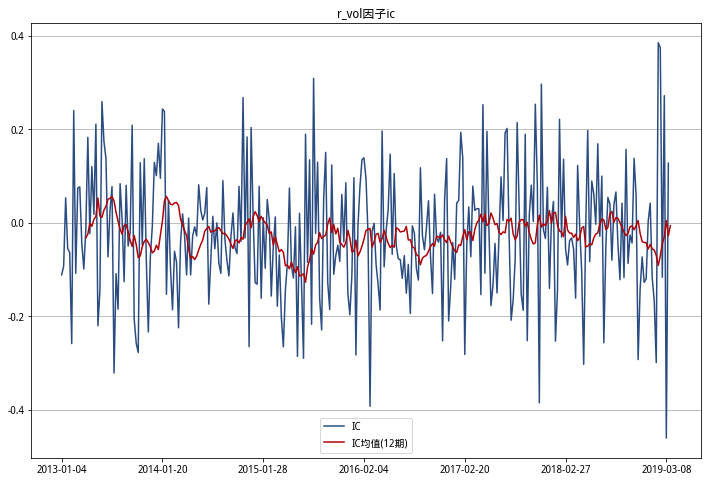

r_skew ic 小于0的个数占比：0.6600660066006601


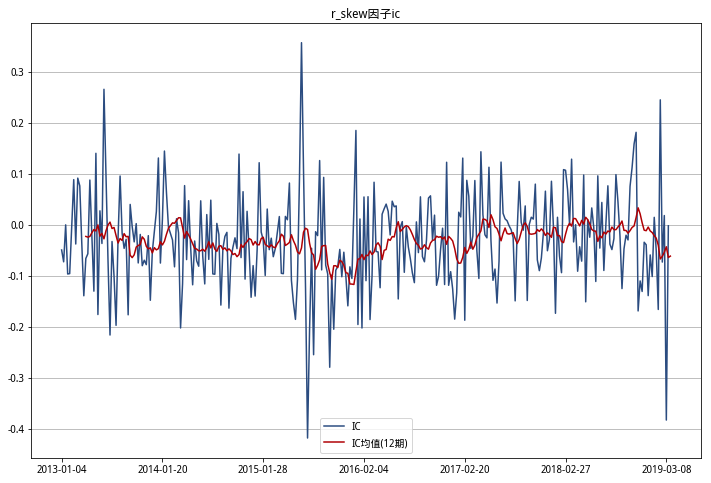

r_kurt ic 小于0的个数占比：0.66996699669967


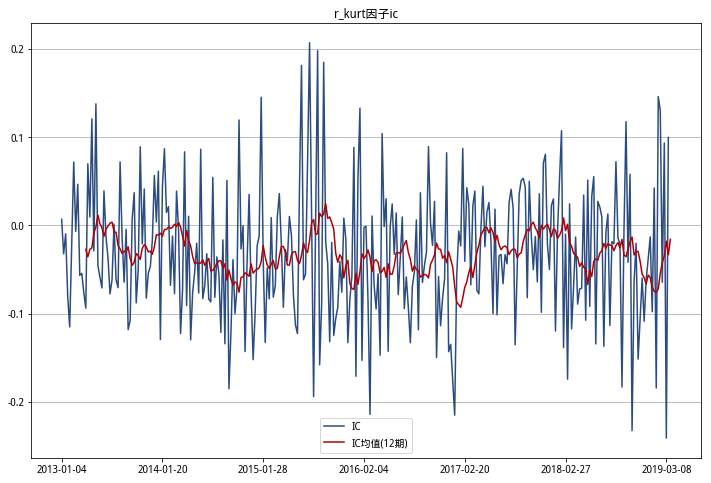

In [16]:
# 'r_vol', 'r_skew', 'r_kurt'
show_factor_ic(ret_df, factor_dict, 'r_vol')
show_factor_ic(ret_df, factor_dict, 'r_skew')
show_factor_ic(ret_df, factor_dict, 'r_kurt')

从以上IC三图可以看出，偏度$RSkew$因子平均IC基本都小于0，且IC负值占比超过6成，预测能力较好。

偏度$RSkew$因子在中证500指数下2013-2019年IC小于0的个数占比为66%，和研报中中证500的IC统计结果近似。受限于研究的内存和因子构建执行时间，我没有使用全市场数据计算，研报中全市场数据的IC小于0的个数占比未验证。

## 4因子换手率

In [13]:
# 展示某因子的换手率
def show_factor_turnover_rate(factor_dict, factor_name):
    y_list = [[], []]

    # 收益率折线图从0开始
    y_list[0].append(np.nan)
    y_list[1].append(np.nan)

    pre_date = None
    for date in factor_dict:
        if type(pre_date) == type(None):
            pre_date = date
            continue

        # pre_date为date的上一个调仓日，这里获取上一个调仓日的因子值
        pre_factor_df = factor_dict[pre_date].dropna()
        pre_factor_df = pre_factor_df.sort_values(by=factor_name)
        # 把上一个调仓日的因子值分为5档
        pre_groups = group_df(pre_factor_df, 5)

        # 当前调仓日
        cur_factor_df = factor_dict[date].dropna()
        cur_factor_df = cur_factor_df.sort_values(by=factor_name)
        # 把当前调仓日的因子值分为5档
        cur_groups = group_df(cur_factor_df, 5)

        # 两个调仓日相同的股票
        g1_merge = pd.merge(pre_groups[0], cur_groups[0], on=[factor_name])
        # 最小分位数换手率
        y_list[0].append(1 - len(g1_merge) / len(pre_groups[0]))

        # 两个调仓日相同的股票
        g5_merge = pd.merge(pre_groups[4], cur_groups[4], on=[factor_name])
        # 最小分位数换手率
        y_list[1].append(1 - len(g5_merge) / len(pre_groups[4]))


        pre_date = date

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
#     ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))  # 设置时间标签显示格式
#     ax.xaxis.set_major_locator(mdate.DayLocator())
    ax.set_title(factor_name + "换手率")

    # for i in range(0, len(y_list)):
    #     yi = y_list[i]
    #     ax.plot(yi, color_list[i], label=label_list[i])

    

    x = np.arange(0, len(factor_dict))
#     print(len(x),len(y_list[0]),len(y_list[1]))
    ax.scatter(x, y_list[0], label='1分位换手率')
    ax.scatter(x, y_list[1], label='5分位换手率')
    
    x = np.arange(0, len(factor_dict),50)
    x_label = []
    for i in range(0,len(factor_dict)):
        if i in x:
            date = list(factor_dict.keys())[i]
            x_label.append(date)
    plt.xticks(x, x_label, rotation='vertical')
    plt.xticks(rotation=360)
    
    legend = ax.legend(loc='lower left', shadow=False)

    plt.grid(axis='y')
    plt.show()

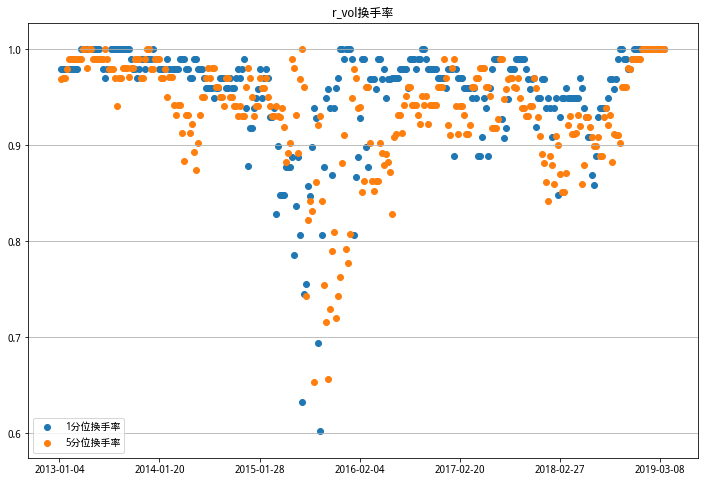

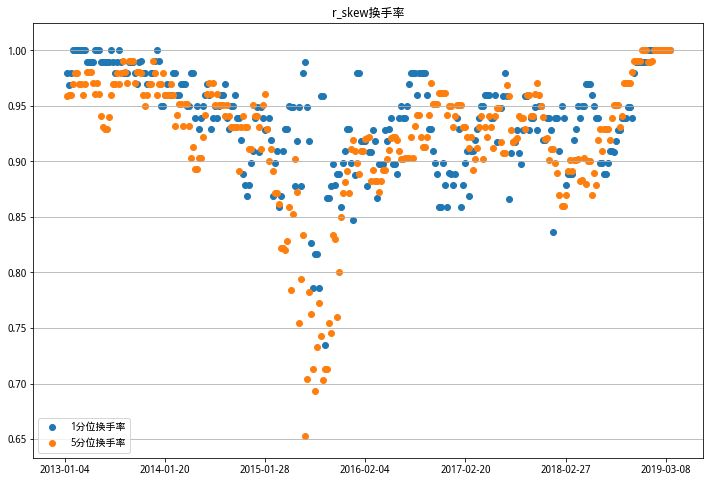

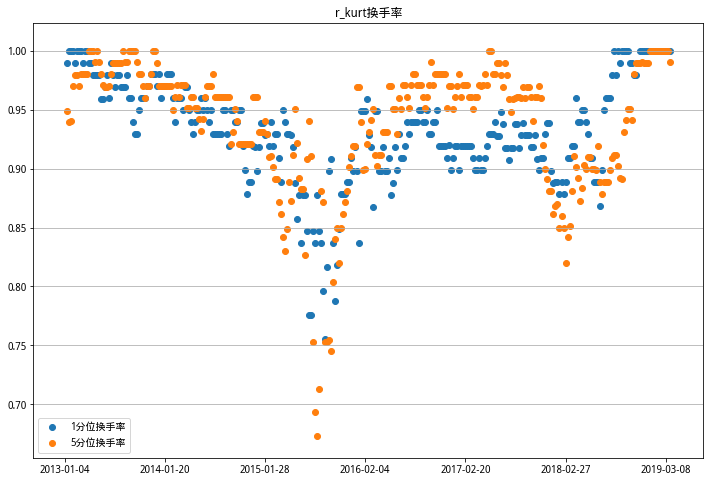

In [14]:
# 'r_vol', 'r_skew', 'r_kurt'
show_factor_turnover_rate(factor_dict, 'r_vol')
show_factor_turnover_rate(factor_dict, 'r_skew')
show_factor_turnover_rate(factor_dict, 'r_kurt')

这里不知道换手率统计的对不对。我只考虑了两个调仓日之间，每个档位更换股票占原股票的比例。偏度$RSkew$因子的换手率比较稳定，基本上每期都要把持仓更换一遍，笑哭😹。看散点分布情况，换手率分布大部分在85%以上，考虑到时间选取和算法的不同，和研报中给出的平均80%换手率也算接近。

# 6总结

本研究从因子分布和因子百分位走势对因子特征做了展示，从累计收益率、多空收益、因子IC、换手率几个角度做实证分析。

总的来说，本研究使用中证500指数2013-2019年的数据选股，对研报中的内容基本上都做了复现，得出结论：三个因子中偏度$RSkew$因子最有效，分组区分度高，比较稳定，收益最高。复现得出的结论基本和研报一致，这篇研报还是挺靠谱的。